<a href="https://colab.research.google.com/github/virb30/churn-prediction/blob/main/Projeto_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado. 

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos. O *churn rate* de determinado período pode ser calculado pela equação:

$$ \frac{nº\ clientes\ que\ cancelaram}{nº\ clientes\ no\ início} $$

### Churn de Receita ou MRR Churn
Enquanto o *churn rate* representa a taxa de cancelamentos em um período pré-determinado, o churn de receita (ou *Monthly Recurring Revenue* - MRR Churn) representa o total de receita perdida em razão desses cancelamentos. 

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [90]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Análise Exploratória

Para tomarmos uma decisão sobre qual algoritmo vamos utilizar, quais serão as etapas de tratamento dos dados ou como iremos avaliar o desempenho do modelo, precisamos conhecer nossos dados. Vamos entender como estão compostas as variáveis:



In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Notamos que a variável `TotalCharges` deveria ser do tipo `float64`, porém notamos que ela é do tipo possui tipo `object` o que nos indica que há pelo menos um registro com tipo `string`, antes de prosseguirmos com a análise, vamos identificar e tratar esses dados: 

In [92]:
# remover registros em que todos os valores são nulos
df = df.dropna(how='all')

#remover duplicados
df = df[~df.duplicated()]

# remover registros onde TotalCharges == ' '
df = df[~(df['TotalCharges'] == ' ')]

# converter TotalCharges para número
df.TotalCharges = pd.to_numeric(df.TotalCharges)

df.count()

customerID          7032
gender              7032
SeniorCitizen       7032
Partner             7032
Dependents          7032
tenure              7032
PhoneService        7032
MultipleLines       7032
InternetService     7032
OnlineSecurity      7032
OnlineBackup        7032
DeviceProtection    7032
TechSupport         7032
StreamingTV         7032
StreamingMovies     7032
Contract            7032
PaperlessBilling    7032
PaymentMethod       7032
MonthlyCharges      7032
TotalCharges        7032
Churn               7032
dtype: int64

Haviam 11 registros cuja variável `TotalCharges` estava em branco, isso provavelmente trata-se de erro de digitação, uma vez que é um valor que não faz sentido para o campo "cobrança total". Vamos ver como ficaram nossas variáveis após esse tratamento:

In [93]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032,7032,7032.000000,7032,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032
unique,7032,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,1421-HCERK,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3549,NaN,3639,4933,NaN,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,NaN,NaN,5163
mean,NaN,NaN,0.162400,NaN,NaN,32.421786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441,NaN
std,NaN,NaN,0.368844,NaN,NaN,24.545260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362,NaN
min,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3794.737500,NaN



### Dicionário de variáveis

Analisando o resumo das variáveis do *dataset* vemos que os nomes das variáveis são bastante descritivos:
  * `customerID` - Identificador do usuário
  * `gender` - Sexo do usuário
  * `SeniorCitizen` - Se o usuário é idoso ou não
  * `Partner` - Se o usuário possui parceiro
  * `Dependents` - Se o usuário tem dependentes
  * `tenure` - Quanto tempo que o usuário utiliza o serviço
  * `PhoneService` - Se o usuário possui serviço de telefonia
  * `MultipleLines` - Se o usuário possui múltiplas linhas
  * `InternetService` - Se o usuário possui serviço de internet
  * `OnlineSecurity` - Se o usuário contratou serviço de segurança online
  * `OnlineBackup` - Se o usuário contratou serviço de backup online
  * `DeviceProtection` - Se o usuário contratou proteção para o dispositivo
  * `TechSupport` - Se o usuário tem suporte técnico
  * `StreamingTV` - Se o usuário possui streaming de TV
  * `StreamingMovies` - Se o usuário possui streaming de filmes
  * `Contract` - Tipo do contrato (mensal ou anual)
  * `PaperlessBilling` - Se o usuário optou por fatura digital
  * `PaymentMethod` - Forma de pagamento
  * `MonthlyCharges`- Despesa mensal
  * `TotalCharges` - Total de despesa do usuário (desde a contratação do serviço)
  * `Churn` - Variável alvo - desistente ou não  


Pela descrição das variáveis podemos separá-las em dois grupos - categóricas e numéricas - da seguinte maneira:

**Numéricas:**
* `tenure`
* `MonthlyCharges`
* `TotalCharges`

**Categóricas:**
  * `gender` - Sexo do usuário
  * `SeniorCitizen` - Se o usuário é idoso ou não
  * `Partner` - Se o usuário possui parceiro
  * `Dependents` - Se o usuário tem dependentes
  * `PhoneService` - Se o usuário possui serviço de telefonia
  * `MultipleLines` - Se o usuário possui múltiplas linhas
  * `InternetService` - Se o usuário possui serviço de internet
  * `OnlineSecurity` - Se o usuário contratou serviço de segurança online
  * `OnlineBackup` - Se o usuário contratou serviço de backup online
  * `DeviceProtection` - Se o usuário contratou proteção para o dispositivo
  * `TechSupport` - Se o usuário tem suporte técnico
  * `StreamingTV` - Se o usuário possui streaming de TV
  * `StreamingMovies` - Se o usuário possui streaming de filmes
  * `Contract` - Tipo do contrato (mensal ou anual)
  * `PaperlessBilling` - Se o usuário optou por fatura digital
  * `PaymentMethod` - Forma de pagamento


Notamos ainda que as variáveis categóricas possuem, no maximo, 4 valores distintos. A seguir vamos separar nossas variáveis por grupos para podermos analisa-las:


In [94]:
# criar listas de variáveis segundo seus tipos
categorical_features = [
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
]

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
target = 'Churn'

### Analisando as *features* numéricas

Vamos analisar as variáveis numéricas de modo a tentar identificar a presença de *outliers* ou ainda estabelecer alguma relação entre variáveis numéricas com nosso alvo.

In [95]:
df[numeric_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


Num primeiro momento, não identificamos *outliers* uma vez que nenhum ponto está desconectado ou muito longe da média, para termos uma visão melhor de como as variáveis estão distribuidas, vamos visualizar os histogramas das mesmas:

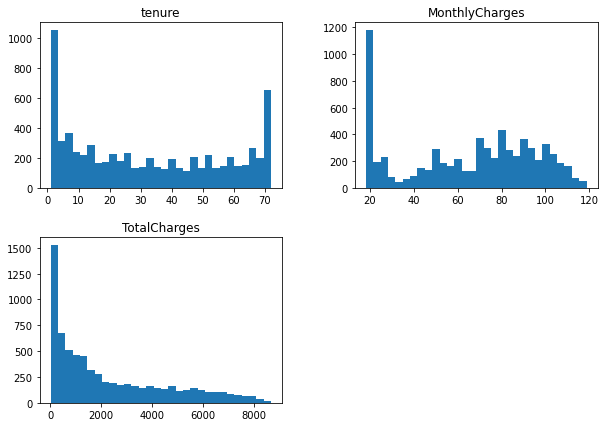

In [96]:
df[numeric_features].hist(bins=30, figsize=(10, 7), grid=False);

Notamos que as variáveis estão bem distribuidas no conjunto, nos mostrando a ausência de *outliers*

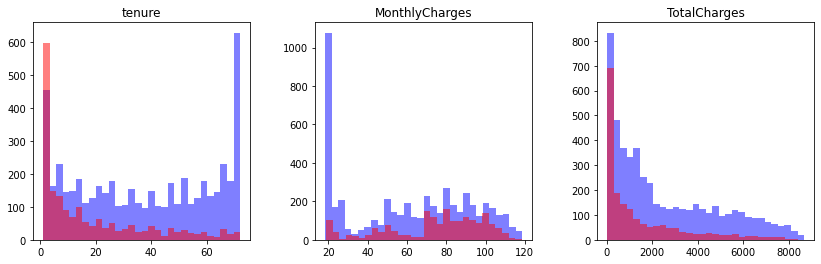

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numeric_features].hist(bins=30, color="blue", alpha=0.5, ax=ax, grid=False);
df[df.Churn == "Yes"][numeric_features].hist(bins=30, color="red", alpha=0.5, ax=ax, grid=False);

Vemos que, quanto maior `tenure` e `TotalCharges` menor é a probabilidade de evasão.

### Analisando as *features* categóricas

Para as variáveis categóricas vamos visualizar como elas estão distribuidas no dataset, utilizaremos os gráficos de barras para melhor visualização:

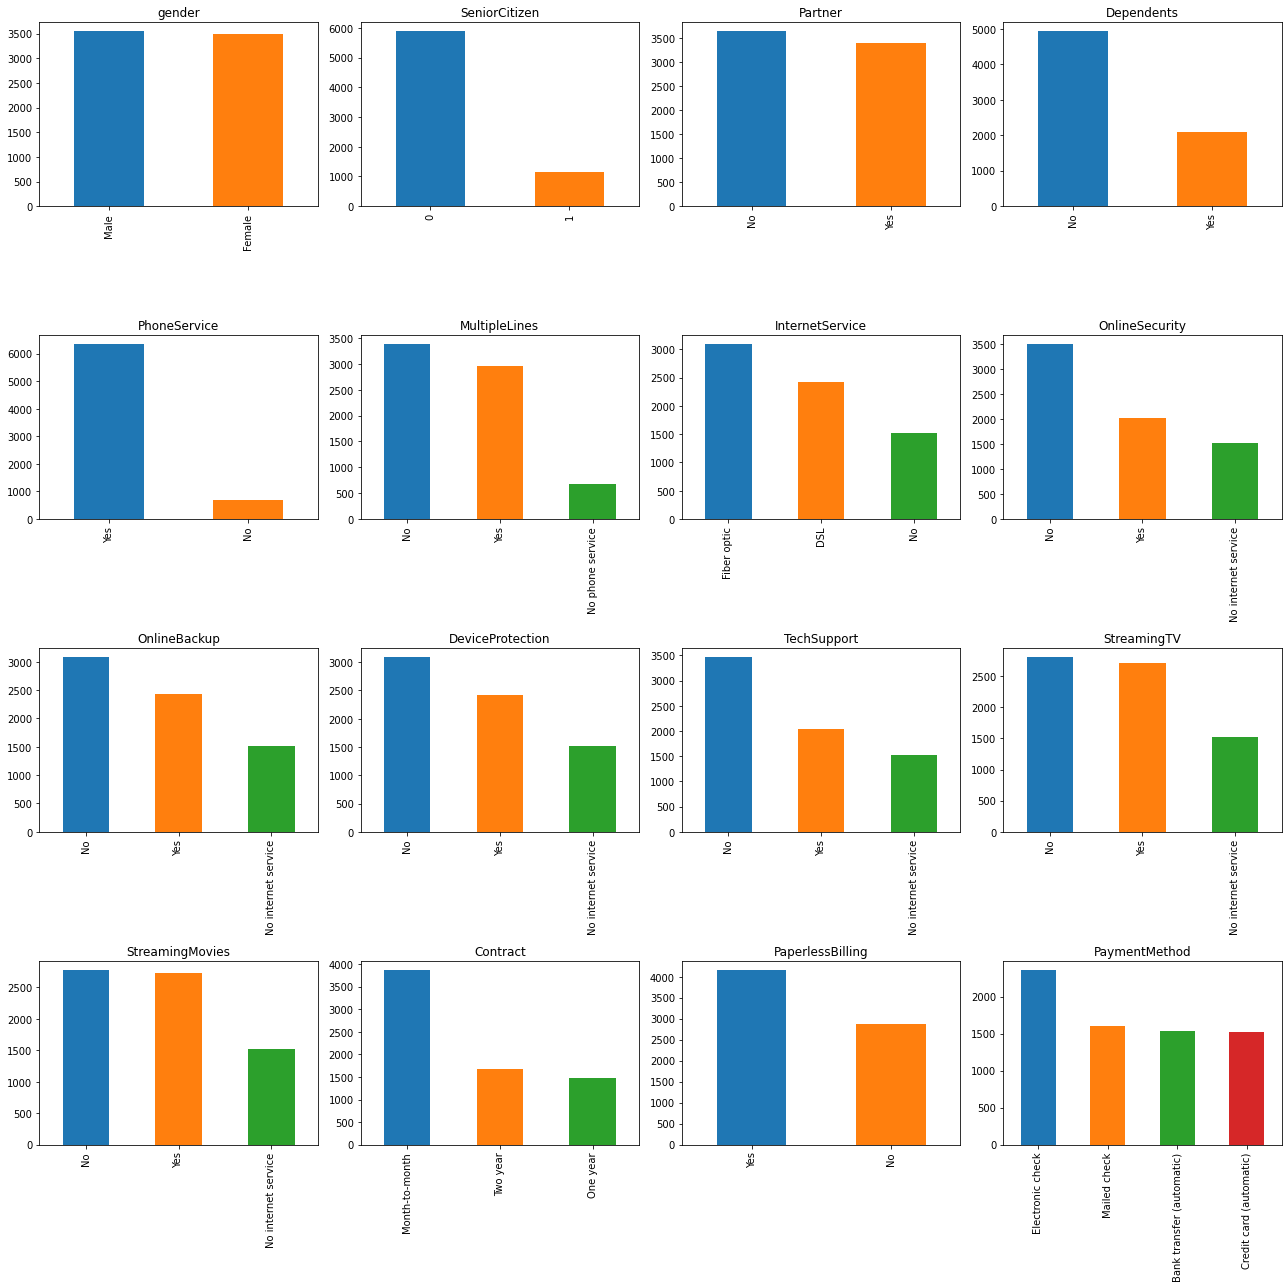

In [98]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(18, 18))
row, col = 0, 0
colors = ['C0', 'C1', 'C2', 'C3']
for i, feature in enumerate(categorical_features):
  if col == COLS - 1:
    row += 1
  col = i % COLS
  df[feature].value_counts().plot.bar(ax=ax[row, col], color=colors).set_title(feature)

plt.tight_layout()

Vemos que idosos e usuários sem serviço de telefone são os menos representados no conjunto de dados.

### Analisando a variável alvo

Verificando a distribuição da variável alvo podemos ver quão desbalanceado está nosso *dataset*. O problema de se usar dados desbalanceados para treinar o modelo é que teremos uma acurácia global alta uma vez que estará enviesado pela a classe majoritária.

Dados desbalanceados podem ser resolvidos:
1. reamostragem - de modo que tenhamos a mesma quantidade para cada alvo
2. coletar mais dados
3. utilizar outras métricas de desempenho, como `precision` e `recall`

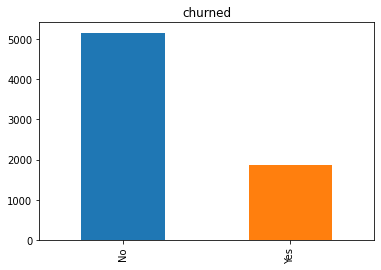

In [99]:
# verificar distribuição da variável Churn
df[target].value_counts().plot.bar(color=['C0', 'C1']).set_title('churned');

### Convertendo a variável alvo

De modo a padronizarmos os dados para utilizar somente números, vamos converter a variável alvo de modo que a classe `Yes` seja 1 e `No` seja 0.

In [100]:
# codificar variável alvo
from sklearn.preprocessing import LabelEncoder

# treinar LabelEncoder
le = LabelEncoder()
le.fit(df[target])

# transformar variável alvo
df[target] = le.transform(df[target])

# visualizar primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Divisão dos dados

Antes de construir o modelo, iremos dividir os dados em dois grupos: treino e teste, utilizaremos a proporção 70% para treino e 30% para teste, também utilizaremos o método `shuffle` para que haja um embaralhamento dos dados e iremos manter a proporção entre as classes para a variável alvo.

In [101]:
# importar os pacotes necessarios
from sklearn.model_selection import train_test_split

# separar variáveis e alvos
X = df.drop('Churn', axis=1)
y = df['Churn']

X.drop('customerID', axis=1, inplace=True)

# separar os conjuntos em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True, stratify=y)


print(f'Tamanho do conjunto de treino: {X_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

Tamanho do conjunto de treino: 4922
Tamanho do conjunto de teste: 2110


## Tratamento dos dados

Com os dados devidamente separados, vamos começar realizando os tratamentos necessários em nosso conjunto de treino seguindo a sequência:
1. Converter variáveis categóricas
2. Padronizar as variáveis numéricas

Como a maioria das variáveis possui duas ou mais categorias sem qualquer relação de ordem entre elas, utilizaremos, para esse *dataset* o *OneHotEncoding* para codificar as variáveis categóricas. Nessa estratégia, para categoria possível de uma variável será criada uma nova coluna e atribuido a ela valor 0 ou 1.


In [102]:
# importar pacotes necessários
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# criar pipeline para transformar as variáveis categóricas
categorical_transformer = Pipeline([
    ('selector', ColumnTransformer([
      ('selector', 'passthrough', categorical_features)
    ], remainder='drop')),
    ('onehot', OneHotEncoder())
]) 

# pipeline para transformar as variáveis numéricas
numeric_transformer = Pipeline([
    ('selector', ColumnTransformer([
      ('selector', 'passthrough', numeric_features)
    ], remainder='drop')),
    ('scalar', StandardScaler())
]) 


# montar dataset que será passado para o modelo
features_transformer = FeatureUnion(transformer_list=[
    ('categorical_features', categorical_transformer)
] + [
     ('numeric_features', numeric_transformer)
])

### Balancear dados

Antes de balancear os dados, faremos uma nova divisão do nosso conjunto de dados de treino que servirão como dados de validação.

Como vimos no início da análise, nossos dados estão desbalanceados, portanto precisamos balanceá-los antes de realizar o treino (`fit`) do modelo. Utilizaremos a técnica de *Under-sampling* que remove amostras da classe majoritária.

In [104]:
# importar pacotes
from imblearn.under_sampling import RandomUnderSampler

# dividir entre treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# fazer resampling
rus = RandomUnderSampler(random_state=0)
X_train_balanced, y_train_balanced = rus.fit_sample(X_train, y_train)

# converter para dataframe
columns = categorical_features + numeric_features
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_balanced = pd.Series(y_train_balanced)

# visualizar primeiras linhas
X_train_balanced.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0,No,Yes,19,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),25.35,566.1
1,Female,0,No,No,25,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.05,461.3
2,Male,1,Yes,No,34,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),85.2,2874.45
3,Male,1,No,No,7,No,No phone service,DSL,No,Yes,No,Yes,No,Yes,Month-to-month,Yes,Electronic check,44.4,265.8
4,Male,0,No,No,51,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Electronic check,19.1,1007.8


## Escolha do modelo

Neste [estudo](https://link.springer.com/article/10.1186/s40537-019-0191-6) foram comparados 4 algoritmos de *Machine Learning* para prever a taxa de rotativade de clientes: Árvores de Decisão, Random Forest, Gradient Boosted Machine Tree “GBM” and XGBoost, como resultado, o algoritmo que apresentou melhor desempenho foi o XGBoost. Portanto, nessa análise utilizaremos esse algoritmo para treinar nosso modelo.

In [144]:
# 1. importar pacotes necessários
from xgboost import XGBClassifier

# 2. Instanciar e escolher os hyperparameters
model = XGBClassifier(
    gamma=1,
    random_state=42,
    objective='binary:logistic'
)

### Juntando tudo

Com as etapas de transformação definidas e o modelo escolhido, vamos colocar todos para funcionar juntos num pipeline. Dessa maneira conseguimos repetir os mesmos passos tanto com o *dataset* de treino quanto de teste

In [145]:
pipeline = Pipeline([
  ('feature_transformer', features_transformer),
  ('classifier', model)
])

pipeline.fit(X_train_balanced, y_train_balanced)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)

## Avaliando o Modelo

Com nossas previsões realizadas, chegou a hora de avaliar o desempenho do nosso modelo, para isso vamos utilizar as métrica AUC ROC, `precision` e `recall`




In [146]:
# importar pacotes
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(f'Relatório de classificação:\n{classification_report(y_val, y_pred, digits=4)}')

# avaliando AUC do modelo
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.8910    0.7445    0.8112       681
           1     0.5085    0.7438    0.6040       242

    accuracy                         0.7443       923
   macro avg     0.6998    0.7441    0.7076       923
weighted avg     0.7907    0.7443    0.7569       923

AUC ROC: 0.7441



Utilizando a configuração padrão do XGBoost conseguimos obter um desempenho satisfatório para esse *dataset* - 78,25% das previsões realizadas corretamente.

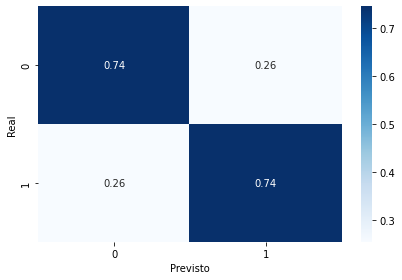

In [147]:
# importar pacotes
import seaborn as sns

fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_val, y_pred, normalize='true'), cmap='Blues', annot=True, ax=ax)

ax.set_ylabel("Real")
ax.set_xlabel("Previsto")

plt.tight_layout()

A matriz de confusão nos mostra dados interessantes sobre nosso modelo (valores sofrer uma leve variação a cada execução uma vez que os dados de treino são selecionados aleatoriamente):
1. 74% das previsões de cancelamento (`churn` = 1 ou *Yes*) foram realizadas corretamente;
2. 74% das previsões de não-cancelamento (`churn` = 0 ou *No*) foram realizadas corretamente;
3. 26% das previsões foram falsos negativos
4. 26% das previsões foram falsos positivos.

Nesse [artigo](https://towardsdatascience.com/churn-prediction-770d6cb582a5), que utiliza um *dataset* semelhante (se não o mesmo) ao nosso, o autor utilizou um modelo baseado em árvore de decisão que apresentou os seguintes resultados para usuários que desistiram do serviço (`churn` = 1): 67% de *precision* e um *recall* de 37%. Em se tratando de *recall* nosso modelo teve desempenho superior ao modelo de Árvore de Decisão.

### Validando Modelo com dados "reais"

Para finalizar a análise vamos realizar uma nova previsão, dessa vez passando os dados de teste (os quais o modelo não teve nenhum contato prévio) e verificar se nosso modelo é genérico o suficiente.

In [148]:
# realizar previsões nos dados de teste
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)

In [149]:
# Avaliar desempenho para dados de teste
print(f'Relatório de classificação:\n{classification_report(y_test, y_pred_test, digits=4)}')

# avaliando AUC do modelo
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_test)))

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.8990    0.7469    0.8159      1549
           1     0.5237    0.7683    0.6228       561

    accuracy                         0.7526      2110
   macro avg     0.7113    0.7576    0.7194      2110
weighted avg     0.7992    0.7526    0.7646      2110

AUC ROC: 0.7576



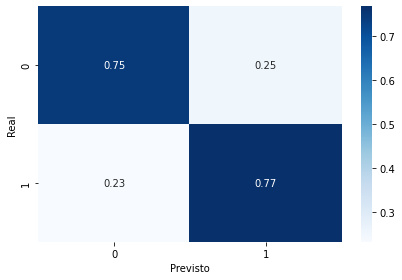

In [150]:
# plotar matriz de confusão para os dados de teste
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='true'), cmap='Blues', annot=True, ax=ax)

ax.set_ylabel("Real")
ax.set_xlabel("Previsto")

plt.tight_layout()

Os resultados para os dados de teste ficaram próximo dos resultados utilizando o *dataset* de validação, portanto, podemos dizer que nosso modelo está genérico suficiente para realizar previsões em dados desconhecidos.

### Melhorando o Modelo

Com uma primeira versão do nosso modelo treinada, vamos ajustar seus parâmetros com o objetivo de melhorar seu desempenho. Podemos chamar essa etapa de *fine tunning*.

### Identificando os melhores parâmetros

Utilizaremos o GridSearch para identificar os melhores parâmetros do nosso modelo. Não iremos incluir todas as variáveis para verificar qual a melhor combinação de parâmetros pois isso elevaria a complexidade computacional e, consequentemente, o GridSearch levaria muito tempo para executar.

Nossa escolha foi baseada na definição dos parâmetros deste [guia](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [151]:
# importar pacotes
from sklearn.model_selection import GridSearchCV

# definir parâmetros que serão avaliados
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500],
    'max_depth': [4, 5, 6],
    'eta': [0.01, 0.05, 0.1],
    'subsample': [0.9],
    'colsample_bytree': [0.2]
}

clf = GridSearchCV(model, parameters)
X_train_transformed = features_transformer.fit_transform(X_train_balanced)
clf.fit(X_train_transformed, y_train_balanced)
print("Melhor: {} usando {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.7669377004122767 usando {'colsample_bytree': 0.2, 'eta': 0.01, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}


Agora que encontramos os melhores parâmetros para nosso modelo, vamos verificar seu desempenho com nosso *dataset* de validação.

In [152]:
# novo modelo com tunning
model_tuned = XGBClassifier(
  learning_rate=0.01,
  n_estimators=100,
  max_depth=4,
  gamma=1,
  subsample=0.9,
  colsample_bytree=0.2,
  objective='binary:logistic',
  eta=0.01,
  random_state=42,
)

# replace pipeline model
pipeline.steps[1] = ('classifier', model_tuned)

# treinar modelo
pipeline.fit(X_train_balanced, y_train_balanced)

# realizar previsões
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)

In [153]:
print(f'Relatório de classificação:\n{classification_report(y_val, y_pred, digits=4)}')

# avaliando AUC do modelo
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.8976    0.7210    0.7997       681
           1     0.4947    0.7686    0.6019       242

    accuracy                         0.7335       923
   macro avg     0.6962    0.7448    0.7008       923
weighted avg     0.7920    0.7335    0.7478       923

AUC ROC: 0.7448



Verificando o desempenho do modelo tunado utilizando o *dataset* de testes.

In [154]:
# realizar previsões
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)

In [155]:
# Avaliar desempenho para dados de teste
print(f'Relatório de classificação:\n{classification_report(y_test, y_pred_test, digits=4)}')

# avaliando AUC do modelo
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_test)))

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.9080    0.7263    0.8070      1549
           1     0.5132    0.7968    0.6243       561

    accuracy                         0.7450      2110
   macro avg     0.7106    0.7615    0.7157      2110
weighted avg     0.8030    0.7450    0.7584      2110

AUC ROC: 0.7615



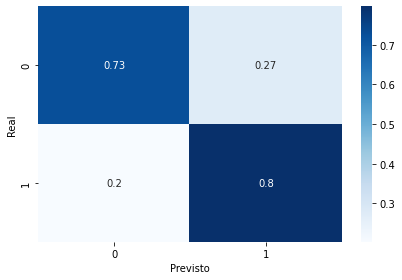

In [156]:
# plotar matriz de confusão para os dados de teste
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='true'), cmap='Blues', annot=True, ax=ax)

ax.set_ylabel("Real")
ax.set_xlabel("Previsto")

plt.tight_layout()

Assim como o modelo sem *tunning*, conseguimos obter desempenho semelhante para os dados de teste, um indício de que nosso modelo pode ser aplicado em situações reais.

## Conclusão

Após essa análise vimos que é possível melhorar o desempenho dos modelos apenas realizando o *tunning* adequado nos seus parâmetros.

No entanto, notamos que a melhora mais significativa foi obtida com o tratamento adequado nos dados e na escolha do modelo.

Vale ressaltar ainda que como nosso conjunto de dados contém dados do usuário somente - e não possui dados referentes à experiência do usuário, por exemplo número de reclamações ou solicitações de suporte - não foi possível realizar nenhuma engenharia que nos desse mais informações e possivelmente melhorar ainda mais o desempenho.

Por fim, nosso modelo obteve um desempenho satisfatório ao conseguir prever corretamente aproximadamente 80% dos casos de `churn`.